Authenticate the google drive

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import os
import pandas as pd

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


Find the id for the file

In [0]:
download_path = os.path.expanduser('/data')
try:
  os.makedirs(download_path)
except FileExistsError:
  pass

In [121]:
cd /data

/data


In [0]:
!unzip train.zip -d /data

Archive:  train.zip
  inflating: /data/train.csv         
  inflating: /data/html_data.csv     


In [0]:
import os
os.chdir('/data')

In [122]:
ls

html_data.csv  submission.csv  test_nvPHrOx.csv  train.csv  train.zip


In [0]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test_nvPHrOx.csv')

In [0]:
train.keys()

Index(['Webpage_id', 'Domain', 'Url', 'Tag'], dtype='object')

In [0]:
pivottable=train.pivot_table(index=['Domain', 'Url','Tag'],  aggfunc=len, fill_value=0).reset_index()

In [0]:
mod=pivottable[pivottable['Webpage_id']!=1]

In [0]:
mod.to_csv('mod.csv')

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

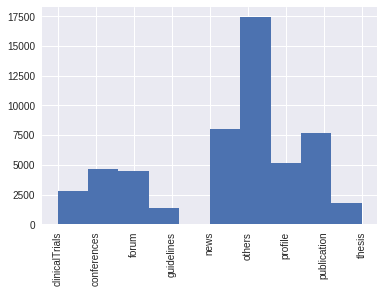

In [0]:
plt.hist(train['Tag'])
plt.xticks(rotation='vertical')

In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
import xgboost as xgb


[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /content/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [80]:
train['Url'].head()

0    http,:,//www.fiercepharma.com/marketing/tecfid...
1    http,:,//www.fiercepharma.com/pharma/novo-equi...
2    http,:,//www.fiercepharma.com/pharma/another-e...
3    http,:,//www.fiercepharma.com/pharma/teva-buy-...
4    http,:,//www.fiercepharma.com/marketing/actres...
Name: Url, dtype: object

In [0]:
#function to convert lists to strings
def conv_string(x):
    a=["".join(Url) for Url in x]
    
    return a
  
def tok_string(x):
    a=[",".join(Url) for Url in x]
    
    return a
  
train['Url']=conv_string(train['Url'])
test['Url']=conv_string(test['Url'])
tok=word_tokenize
train['Url']=[tok(w) for w in train['Url']]
test['Url']=[tok(w) for w in test['Url']]
train['Url']=tok_string(train['Url'])
test['Url']=tok_string(test['Url'])  
lemmatizer=WordNetLemmatizer()
train['Url']=[lemmatizer.lemmatize(w) for w in train['Url']]
test['Url']=[lemmatizer.lemmatize(w) for w in test['Url']]
train['Url']=conv_string(train['Url'])
test['Url']=conv_string(test['Url'])

In [0]:
lblencdr=preprocessing.LabelEncoder()
y=lblencdr.fit_transform(train['Tag'].values)

In [82]:
type(train.Url)

pandas.core.series.Series

In [83]:
train['Url'].head()

0    http,:,//www.fiercepharma.com/marketing/tecfid...
1    http,:,//www.fiercepharma.com/pharma/novo-equi...
2    http,:,//www.fiercepharma.com/pharma/another-e...
3    http,:,//www.fiercepharma.com/pharma/teva-buy-...
4    http,:,//www.fiercepharma.com/marketing/actres...
Name: Url, dtype: object

In [0]:
#train.Url.str.join('').head()

0    http://www.fiercepharma.com/marketing/tecfider...
1    http://www.fiercepharma.com/pharma/novo-equipp...
2    http://www.fiercepharma.com/pharma/another-exe...
3    http://www.fiercepharma.com/pharma/teva-buy-bi...
4    http://www.fiercepharma.com/marketing/actress-...
Name: Url, dtype: object

In [0]:
X_train, X_val, y_train, y_val=train_test_split(train['Url'],y, stratify=y,
                                               random_state=1,
                                               test_size=0.2,
                                               shuffle=True)

In [85]:
print(X_train.shape)
print(X_val.shape)

(42757,)
(10690,)


In [0]:
vect=TfidfVectorizer(max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words='english', binary=False).fit(list(X_train)+list(X_val))
X_train_vect=vect.transform(X_train)
x_valid_vect=vect.transform(X_val)

In [88]:
model = LogisticRegression(C=10.0)
model.fit(X_train_vect, y_train)
predictions=model.predict(vect.transform(X_val))
print(f1_score(predictions, y_val, average='micro'))


0.9712815715622076


In [98]:
model=MultinomialNB()
model.fit(X_train_vect, y_train)
predictions=model.predict(vect.transform(X_val))
print(f1_score(predictions, y_val, average='micro'))


0.9258185219831618


In [126]:
nb_model = MultinomialNB()
# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

my_scorer = metrics.make_scorer(f1_score,average='micro', greater_is_better=True)
# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=my_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(X_train_vect, y_train) 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
predictions=model.predict(vect.transform(X_val))
print(f1_score(predictions, y_val, average='micro'))    

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] nb__alpha=0.001 .................................................
[CV] nb__alpha=0.001 .................................................
[CV] ........ nb__alpha=0.001, score=0.9197418268556194, total=   0.3s
[CV] nb__alpha=0.01 ..................................................
[CV] ........ nb__alpha=0.001, score=0.9209861526946108, total=   0.3s
[CV] nb__alpha=0.01 ..................................................


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s


[CV] ......... nb__alpha=0.01, score=0.9266170899396661, total=   0.2s
[CV] nb__alpha=0.1 ...................................................
[CV] ......... nb__alpha=0.01, score=0.9287050898203593, total=   0.3s
[CV] nb__alpha=0.1 ...................................................


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s


[CV] .......... nb__alpha=0.1, score=0.9451382068191385, total=   0.2s
[CV] nb__alpha=1 .....................................................
[CV] .......... nb__alpha=0.1, score=0.9469966317365269, total=   0.2s
[CV] nb__alpha=1 .....................................................
[CV] ............ nb__alpha=1, score=0.8968710537393012, total=   0.2s
[CV] nb__alpha=10 ....................................................
[CV] ............ nb__alpha=1, score=0.8985310628742516, total=   0.2s
[CV] nb__alpha=10 ....................................................
[CV] ........... nb__alpha=10, score=0.5801880173986249, total=   0.3s
[CV] nb__alpha=100 ...................................................
[CV] ........... nb__alpha=10, score=0.5726047904191617, total=   0.3s
[CV] nb__alpha=100 ...................................................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s


[CV] .......... nb__alpha=100, score=0.3309480379776437, total=   0.4s
[CV] .......... nb__alpha=100, score=0.3340662425149701, total=   0.3s


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.1s finished


Best score: 0.946
Best parameters set:
	nb__alpha: 0.1
0.9514499532273153


In [113]:
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(X_train_vect, y_train)
predictions=model.predict(vect.transform(X_val))
print(f1_score(predictions, y_val, average='micro'))

0.9514499532273153


In [137]:
lr_model = LogisticRegression()
# Create the pipeline 
clf = pipeline.Pipeline([('lr', lr_model)])

my_scorer = metrics.make_scorer(f1_score, average='micro', greater_is_better=True)
# parameter grid
param_grid = {'lr__penalty': ('l1', 'l2'),
              'lr__C': [0.01, 0.1, 1, 10, 100]
             }

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=my_scorer,
                                 verbose=10, n_jobs=8, iid=True, refit=True, cv=5)

# Fit Grid Search Model
model.fit(X_train_vect, y_train) 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
predictions=model.predict(vect.transform(X_val))
print(f1_score(predictions, y_val, average='micro'))    

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] lr__C=0.01, lr__penalty=l1 ......................................
[CV] lr__C=0.01, lr__penalty=l1 ......................................
[CV] lr__C=0.01, lr__penalty=l1 ......................................
[CV] lr__C=0.01, lr__penalty=l1 ......................................
[CV] lr__C=0.01, lr__penalty=l1 ......................................
[CV] lr__C=0.01, lr__penalty=l2 ......................................
[CV] lr__C=0.01, lr__penalty=l2 ......................................
[CV] lr__C=0.01, lr__penalty=l2 ......................................
[CV]  lr__C=0.01, lr__penalty=l2, score=0.3851730589335828, total=  23.5s
[CV] lr__C=0.01, lr__penalty=l2 ......................................
[CV]  lr__C=0.01, lr__penalty=l2, score=0.3841028638223261, total=  23.8s
[CV] lr__C=0.01, lr__penalty=l2 ......................................
[CV]  lr__C=0.01, lr__penalty=l2, score=0.38473228898760814, total=  23.8s


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   24.6s


[CV] lr__C=0.1, lr__penalty=l1 .......................................
[CV]  lr__C=0.01, lr__penalty=l1, score=0.3929865575686733, total=  26.8s
[CV] lr__C=0.1, lr__penalty=l1 .......................................
[CV]  lr__C=0.01, lr__penalty=l1, score=0.39361702127659576, total=  26.9s
[CV] lr__C=0.1, lr__penalty=l1 .......................................
[CV]  lr__C=0.01, lr__penalty=l1, score=0.39241839241839244, total=  27.4s
[CV] lr__C=0.1, lr__penalty=l1 .......................................
[CV]  lr__C=0.01, lr__penalty=l1, score=0.3931244153414406, total=  27.7s
[CV] lr__C=0.1, lr__penalty=l1 .......................................
[CV]  lr__C=0.01, lr__penalty=l1, score=0.39302842437712016, total=  28.5s
[CV] lr__C=0.1, lr__penalty=l2 .......................................
[CV]  lr__C=0.01, lr__penalty=l2, score=0.38226693180488946, total=  24.3s
[CV] lr__C=0.1, lr__penalty=l2 .......................................


[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   49.1s


[CV]  lr__C=0.01, lr__penalty=l2, score=0.3824733824733824, total=  24.5s
[CV] lr__C=0.1, lr__penalty=l2 .......................................
[CV]  lr__C=0.1, lr__penalty=l2, score=0.8009351256575102, total=  38.2s
[CV] lr__C=0.1, lr__penalty=l2 .......................................
[CV]  lr__C=0.1, lr__penalty=l2, score=0.8130699088145896, total=  38.0s
[CV] lr__C=0.1, lr__penalty=l2 .......................................
[CV]  lr__C=0.1, lr__penalty=l2, score=0.8029700654817586, total=  37.9s
[CV] lr__C=1, lr__penalty=l1 .........................................
[CV]  lr__C=0.1, lr__penalty=l1, score=0.7759205143191116, total= 1.0min
[CV] lr__C=1, lr__penalty=l1 .........................................
[CV]  lr__C=0.1, lr__penalty=l1, score=0.783132530120482, total= 1.1min
[CV] lr__C=1, lr__penalty=l1 .........................................
[CV]  lr__C=0.1, lr__penalty=l1, score=0.79249473930325, total= 1.2min
[CV] lr__C=1, lr__penalty=l1 ....................................

[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  1.6min


[CV]  lr__C=0.1, lr__penalty=l1, score=0.778999064546305, total= 1.2min
[CV] lr__C=1, lr__penalty=l1 .........................................
[CV]  lr__C=0.1, lr__penalty=l1, score=0.7835497835497836, total= 1.2min
[CV] lr__C=1, lr__penalty=l2 .........................................
[CV]  lr__C=0.1, lr__penalty=l2, score=0.8064101064451984, total=  37.8s
[CV] lr__C=1, lr__penalty=l2 .........................................
[CV]  lr__C=0.1, lr__penalty=l2, score=0.8022698022698023, total=  36.3s
[CV] lr__C=1, lr__penalty=l2 .........................................
[CV]  lr__C=1, lr__penalty=l2, score=0.9491525423728814, total=  48.2s
[CV] lr__C=1, lr__penalty=l2 .........................................
[CV]  lr__C=1, lr__penalty=l2, score=0.9525368248772504, total=  50.0s
[CV] lr__C=1, lr__penalty=l2 .........................................
[CV]  lr__C=1, lr__penalty=l2, score=0.9499532273152479, total=  49.5s
[CV] lr__C=10, lr__penalty=l1 ........................................

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  3.4min


[CV]  lr__C=1, lr__penalty=l1, score=0.9443600233781414, total= 2.4min
[CV] lr__C=10, lr__penalty=l1 ........................................
[CV]  lr__C=1, lr__penalty=l1, score=0.9473499473499474, total= 3.7min
[CV] lr__C=10, lr__penalty=l1 ........................................
[CV]  lr__C=1, lr__penalty=l1, score=0.9517184942716858, total= 5.5min
[CV] lr__C=10, lr__penalty=l2 ........................................
[CV]  lr__C=1, lr__penalty=l1, score=0.9474792373377003, total= 5.6min
[CV] lr__C=10, lr__penalty=l2 ........................................
[CV]  lr__C=10, lr__penalty=l1, score=0.9690022224821616, total= 4.3min
[CV] lr__C=10, lr__penalty=l2 ........................................
[CV]  lr__C=10, lr__penalty=l2, score=0.9659848042080654, total= 1.1min
[CV] lr__C=10, lr__penalty=l2 ........................................
[CV]  lr__C=10, lr__penalty=l2, score=0.9710077156885667, total= 1.2min
[CV] lr__C=10, lr__penalty=l2 ........................................
[CV

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  9.3min


[CV]  lr__C=10, lr__penalty=l2, score=0.9672476313019066, total= 1.1min
[CV] lr__C=100, lr__penalty=l1 .......................................
[CV]  lr__C=10, lr__penalty=l2, score=0.9703989703989705, total= 1.1min
[CV] lr__C=100, lr__penalty=l1 .......................................
[CV]  lr__C=100, lr__penalty=l1, score=0.9691408533021625, total= 9.0min
[CV] lr__C=100, lr__penalty=l1 .......................................
[CV]  lr__C=10, lr__penalty=l1, score=0.9713517305893359, total=14.7min
[CV] lr__C=100, lr__penalty=l2 .......................................
[CV]  lr__C=100, lr__penalty=l1, score=0.968768276991461, total= 8.6min
[CV] lr__C=100, lr__penalty=l2 .......................................
[CV]  lr__C=10, lr__penalty=l1, score=0.9691408533021625, total=16.3min
[CV] lr__C=100, lr__penalty=l2 .......................................
[CV]  lr__C=100, lr__penalty=l2, score=0.9692577440093513, total= 1.7min
[CV] lr__C=100, lr__penalty=l2 .....................................

[Parallel(n_jobs=8)]: Done  41 out of  50 | elapsed: 19.8min remaining:  4.3min


[CV]  lr__C=100, lr__penalty=l2, score=0.9727612812719195, total= 1.7min
[CV] lr__C=100, lr__penalty=l2 .......................................
[CV]  lr__C=100, lr__penalty=l1, score=0.9725274725274725, total=10.6min
[CV]  lr__C=100, lr__penalty=l1, score=0.9713517305893359, total=10.9min
[CV]  lr__C=100, lr__penalty=l2, score=0.9707670720299345, total= 1.4min
[CV]  lr__C=100, lr__penalty=l2, score=0.9702889226810153, total= 1.1min
[CV]  lr__C=100, lr__penalty=l2, score=0.9718029718029718, total= 1.2min


[Parallel(n_jobs=8)]: Done  47 out of  50 | elapsed: 21.0min remaining:  1.3min


[CV]  lr__C=10, lr__penalty=l1, score=0.9734627075052606, total=17.7min
[CV]  lr__C=100, lr__penalty=l1, score=0.9705159705159705, total= 4.7min
[CV]  lr__C=10, lr__penalty=l1, score=0.9716859716859717, total=17.7min


[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed: 23.1min finished


Best score: 0.971
Best parameters set:
	lr__C: 100
	lr__penalty: 'l2'
0.9738072965388214


In [0]:
y_predict=model.predict(vect.transform(test['Url']))

In [139]:
test['Tag']=lblencdr.inverse_transform(y_predict)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [140]:
test.keys()

Index(['Webpage_id', 'Domain', 'Url', 'Tag'], dtype='object')

In [0]:
samp=test.loc[:,['Webpage_id','Tag']]

In [0]:
samp.to_csv('submission.csv', index=False)

In [94]:
ls

html_data.csv  submission.csv  test_nvPHrOx.csv  train.csv  train.zip


In [0]:
from google.colab import files
#files.download('')

In [0]:
files.download('submission.csv')

In [0]:
from google.colab import files

In [0]:
files.download('test_nvPHrOx (1).csv')

In [0]:
ls

html_data.csv  submission.csv  test_nvPHrOx (1).csv  train.csv
mod.csv        test.csv        test_nvPHrOx.csv      train.zip
